In [58]:
import json
import random
import os
import numpy as np
from PIL import Image
import copy

def get_horizontal_frames(num_img, frames):
    equator_threshold = 0.4
    center_pt = np.zeros(3)
    
    # initialization of dict_list
    selected_frame_dict_list = []
    for i in range(num_img):
        s_f_dict = {}
        theta = 2*np.pi/num_img * i
        base_vector = np.array([np.sin(theta), np.cos(theta)])
        s_f_dict["base_vector"] = base_vector
        s_f_dict["selected_frame_inner_product"] = -1000
        s_f_dict["selected_frame"] = frames[0]
        selected_frame_dict_list.append(s_f_dict)

    # select num_img frames
    for frame in frames:
        transform_matrix = frame["transform_matrix"]
        t_m_array = np.array(transform_matrix) # =~ c2w ?

        # z = t_m_array[2, 3] height
        if t_m_array[2,3] >= equator_threshold:
            continue
            
        # xy plane vector
        vector = t_m_array[[0, 1], 3]- center_pt[[0, 1]]
        direction = vector / np.linalg.norm(vector)

        # the nearest inner product to 1 -> select as a frame
        for i, s_f_dict in enumerate(selected_frame_dict_list):
            # inner_product = np.dot(direction, s_f_dict["base_vector"])
            inner_product = np.dot(direction, s_f_dict["base_vector"])
            if s_f_dict["selected_frame_inner_product"] < inner_product:
                selected_frame_dict_list[i]["selected_frame"] = frame
                selected_frame_dict_list[i]["selected_frame_inner_product"] = inner_product

    selected_frames = [s_f_dict["selected_frame"] for s_f_dict in selected_frame_dict_list]
    return selected_frames

def modify_dict_data_horizontal(num_img, dict_data):
    frames = dict_data["frames"]

    selected_frames = get_horizontal_frames(num_img, frames)

    modified_dict_data = copy.deepcopy(dict_data)
    modified_dict_data["frames"] = selected_frames
    return modified_dict_data
    
def get_dict_data_from_json_path(input_json_path):
    with open(input_json_path, 'r') as f:
        dict_data = json.load(f)
    return dict_data

def save_dict_data(dict_data, output_json_path):
    with open(output_json_path, "w") as f:
        json.dump(dict_data, f)
        #json.dump(dict_data, f, indent=4)
        
def do_io_json_horizontal(in_dir, out_dir, num_train_img_list):
    in_json_path = f"{in_dir}/train_all.json"
    dict_data = get_dict_data_from_json_path(in_json_path)
    
    for num_img in num_train_img_list:
        modified_dict_data = modify_dict_data_horizontal(num_img, dict_data)
        out_json_path = f"{out_dir}/train_all_{num_img}_horizontal.json"
        save_dict_data(modified_dict_data, out_json_path)

# image
ckpt_path = "/home/ccl/Datasets/NeRF/ScanNerf/"
scene_list = sorted(os.listdir(ckpt_path))

def copy_image_of_json(in_json_path, in_image_dir, out_dir, scene):
    with open(in_json_path, 'r') as f:
        dict_data = json.load(f)
    frames = dict_data["frames"]
    
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
    
    imgs = []
    for i, frame in enumerate(frames):
        file_path = frame["file_path"]
        img_path = f"{in_image_dir}/{file_path}.png"
        img = Image.open(img_path)
        num_zero_padding = len(str(len(frames)))
        img.save(f"{out_dir}/{i:0{num_zero_padding}}_{os.path.basename(file_path)}.png")
        imgs.append(img)

    imgs[0].save(f"{out_dir}/{scene}_{len(imgs)}.gif",save_all=True, append_images=imgs[1:],optimize=True, duration=350, loop=0)

    
def save_image_jsons(num_train_img):
    for scene in scene_list:
        in_json_dir = f"./test/{scene}/"
        in_json_path = f"{in_json_dir}/train_all_{num_train_img}_horizontal.json"
        in_image_dir = f"/home/ccl/Datasets/NeRF/ScanNerf/{scene}"
        out_dir = f"{in_json_dir}/{num_train_img}"
        copy_image_of_json(in_json_path, in_image_dir, out_dir, scene)
        
def make_json_img_test(scene, num_train_img_list):
    train_data_ckpt_dir = "/home/ccl/Datasets/NeRF/ScanNerf"
    in_dir = f"{train_data_ckpt_dir}/{scene}/"
    out_dir = f"./test/{scene}"
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
    do_io_json_horizontal(in_dir, out_dir, num_train_img_list)

    for num_train_img in num_train_img_list:
        in_json_dir = f"./test/{scene}"
        in_json_path = f"{in_json_dir}/train_all_{num_train_img}_horizontal.json"
        in_img_dir = f"{train_data_ckpt_dir}/{scene}"
        out_img_dir = f"{out_dir}/{num_train_img}"

        copy_image_of_json(in_json_path, in_img_dir, out_img_dir, scene)
        
# for test
make_json_img_test("airplane1", [25, 100])

In [59]:
def make_json_all_scene(num_train_img_list):
    ckpt_dir = "/home/ccl/Datasets/NeRF/ScanNerf"
    scene_list = sorted(os.listdir(ckpt_dir))

    for scene in scene_list:
        input_dir = f"{ckpt_dir}/{scene}/"

        # for test
        new_dir = f"./test"
        if not os.path.exists(new_dir):
            os.mkdir(new_dir)

        new_dir += f"/{scene}"
        if not os.path.exists(new_dir):
            os.mkdir(new_dir)

        make_json_img_test(scene, num_train_img_list)

# for actual 

make_json_all_scene([3, 10, 25])

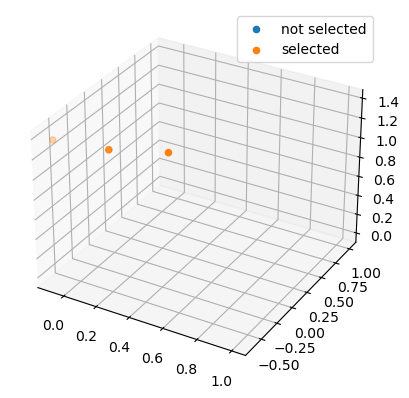

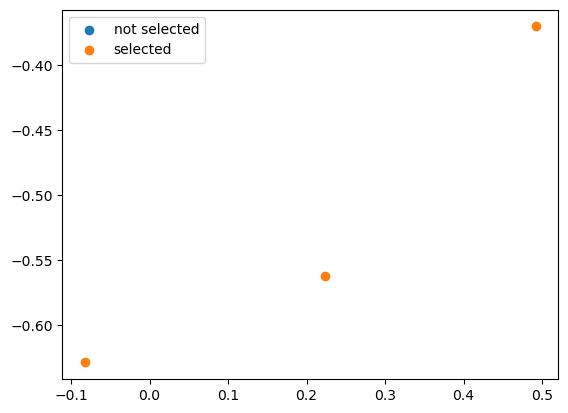

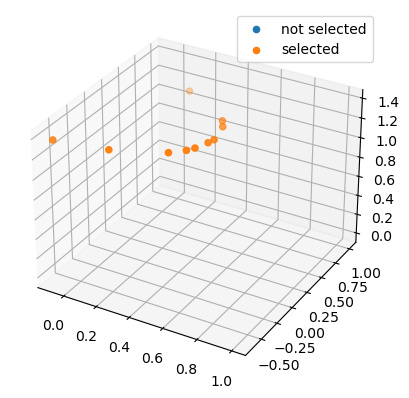

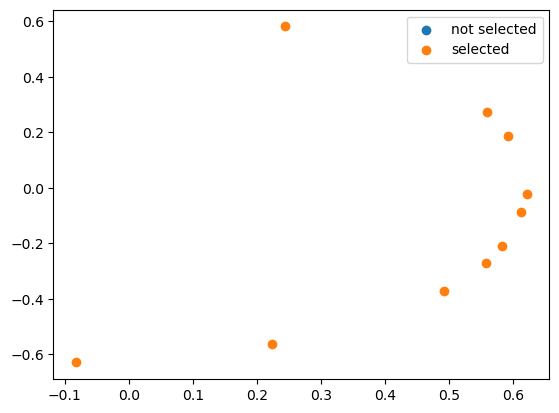

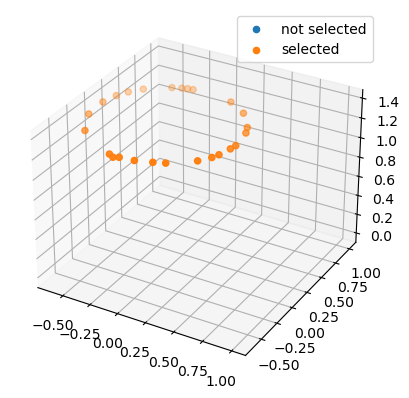

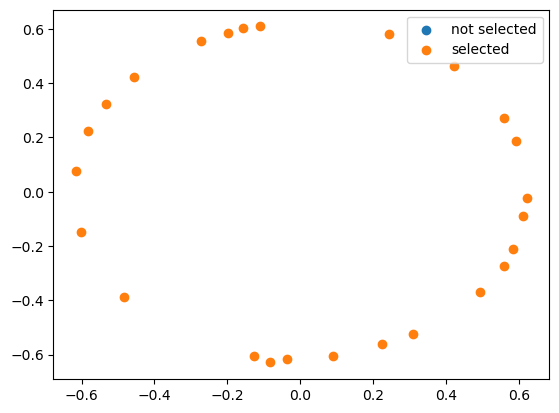

In [61]:
import matplotlib.pyplot as plt
import numpy as np

def xyz(t_m_arrays): # transform matrices np.array
    return t_m_arrays[:,0,3], t_m_arrays[:,1,3], t_m_arrays[:,2,3]

def xy(t_m_arrays): # transform matrices np.array
    return t_m_arrays[:,0,3], t_m_arrays[:,1,3]
def plot_filter(condition, labels, t_m_arrays):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    inlier = np.where(condition)
    outlier = np.where(np.logical_not(condition))
    ax.scatter(*xyz(t_m_arrays[outlier]), label=labels[1])
    ax.scatter(*xyz(t_m_arrays[inlier]), label=labels[0])
    ax.legend()
    #fig.savefig(f"{out_ckpt_dir}/{scene}/{filename}")
    
    c2ws_filtered = t_m_arrays[inlier]
    
def plot_2d_filter(condition, labels, t_m_arrays):
    fig = plt.figure()
    ax = fig.add_subplot()
    inlier = np.where(condition)
    outlier = np.where(np.logical_not(condition))
    ax.scatter(*xy(t_m_arrays[outlier]), label=labels[1])
    ax.scatter(*xy(t_m_arrays[inlier]), label=labels[0])
    ax.legend()
    #fig.savefig(f"{out_ckpt_dir}/{scene}/{filename}")
    
    c2ws_filtered = t_m_arrays[inlier]

ckpt_dir = "/home/ccl/Datasets/NeRF/ScanNerf"
#scene_list = sorted(os.listdir(path))
scene = "airplane1"

input_dir = f"{ckpt_dir}/{scene}"
    
input_json_path = f"{input_dir}/train_all.json"
dict_data = get_dict_data_from_json_path(input_json_path)
frames = dict_data["frames"]

t_m_arrays = np.array([np.array(frame["transform_matrix"]) for frame in frames])

equator_threshold = 0.4
for num_img in [3, 10, 25]:
    modified_dict_data = modify_dict_data_horizontal(num_img, dict_data)
    selected_frames = modified_dict_data["frames"]
    selected_t_m_arrays = np.array([np.array(frame["transform_matrix"]) for frame in selected_frames]) # =~ c2ws?
    
    #plot_filter(t_m_arrays[:,2,3] <= equator_threshold, ["equator", "not equator"], "equator_selection.jpeg", t_m_arrays)
    plot_filter(selected_t_m_arrays[:,2,3] < equator_threshold+20, ["selected", "not selected"], t_m_arrays)
    plot_2d_filter(selected_t_m_arrays[:,2,3] < equator_threshold+20, ["selected", "not selected"], t_m_arrays)
